In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import gc
import numpy as np

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
wordcount_thres =1
hidden_size = 100

In [3]:
lines = open('data/chatcorpus.txt', encoding='utf-8',
             errors='ignore').read().split('\n')

#define split
def mysplit(txt):
    txt = clean_text(txt)
    tokens = re.findall(r'\w+|[^\s\w]+', txt)
    return [t for t in tokens if t!=""]
    
#remove abbreviations
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

questions = []
answers = []
for line in lines:
    line = line.split("\t")
    ques = mysplit(line[0])
    ans = mysplit(line[1])
    questions.append(ques)
    answers.append(ans)
print("number of question-answer pairs:",len(questions))

ntrain_samples =  len(questions)-20 #use 20 samples for testing
max_len = max([len(q) for q in questions])
np.random.seed(0)
inds = np.random.choice(len(questions),20,replace=False)
test_questions = [questions[i] for i in inds]
test_answers = [answers[i] for i in inds]
questions=[questions[i] for i in range(len(questions)) if i not in inds]
answers=[answers[i] for i in range(len(answers)) if i not in inds]
print(len(questions),ntrain_samples)

#encoder
# get vocabulary
wordcount = {}
for line in questions:
    for word in line:
        wordcount[word] = wordcount.get(word,0)+1
vocabulary = [w for w,c in wordcount.items() if c>=wordcount_thres]
vocabulary = ['<EOS>', '<OUT>']+vocabulary #add tokens
vocab={}
i = len(vocab)
for token in vocabulary:
    vocab[token] = i
    i += 1
VOCAB_SIZE = len(vocab)
print("encoder vocabulary_size:",VOCAB_SIZE)  

#decoding
vocabulary=set()
for line in answers:
    vocabulary.update(line)
vocabulary = list(vocabulary)
vocabulary = ['<SOS>', '<EOS>']+vocabulary #add tokens
dec_vocab={w:i for i,w in enumerate(vocabulary)}
DEC_VOCAB_SIZE = len(vocabulary)
print("decoder vocabulary_size:",DEC_VOCAB_SIZE)  
inv_vocab = {i:w for w,i in dec_vocab.items()}#for decoding


def get_encoderinput(questions):
    encoder_inp = []
    for line in questions:
        lst = []
        for word in line:
            if word not in vocab:
                lst.append(vocab['<OUT>'])
            else:
                lst.append(vocab[word])
        lst = torch.tensor(lst, dtype=torch.long, device=device).view(-1, 1)
        encoder_inp.append(lst)
    return encoder_inp
encoder_inp = get_encoderinput(questions)

def get_decoderinput(answers):
    decoder_inp = []
    for line in answers:
        lst = [] #vocab["<SOS>"]
        for word in line:
            lst.append(dec_vocab[word]) 
        lst.append(dec_vocab["<EOS>"])
        lst = torch.tensor(lst, dtype=torch.long, device=device).view(-1, 1)
        decoder_inp.append(lst)
    return decoder_inp
decoder_inp = get_decoderinput(answers)

# save memory space
gc.collect()  

number of question-answer pairs: 109
89 89
encoder vocabulary_size: 210
decoder vocabulary_size: 243


0

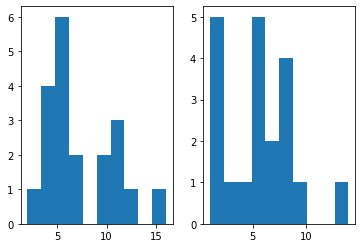

In [4]:
ques_len = [len(q) for q in test_questions]
ans_len = [len(a) for a in test_answers]

plt.figure()
plt.subplot(1,2,1)
plt.hist(ques_len,bins=10)
plt.subplot(1,2,2)
plt.hist(ans_len,bins=10)
plt.show()

In [5]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        if rnn=="RNN":
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            return output, hidden
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            return output, (hidden, cell) 

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        if rnn=="RNN":
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell=None):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            output = self.softmax(self.out(output[0]))
            return output, hidden
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            output = self.softmax(self.out(output[0]))
            return output, (hidden, cell) 

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True)
        if rnn=="RNN":
            self.rnn = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True)
        elif rnn=="GRU":
            self.rnn = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True)
            
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
#         output, hidden = self.rnn(output, hidden)
        if rnn in ["RNN","GRU"]:
            output, hidden = self.rnn(output, hidden)
            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, hidden, attn_weights
        else:
            output, (hidden, cell) = self.rnn(output, (hidden, cell))
            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, (hidden, cell), attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [7]:
def evaluate(encoder, decoder, sentence, max_length=max_len):
    with torch.no_grad():
        input_tensor = get_encoderinput([sentence])[0]
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        if rnn not in ["RNN","GRU"]:
            encoder_cell = encoder.initHidden()
            
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
            if rnn in ["RNN","GRU"]:
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
            else:
                encoder_output, (encoder_hidden,encoder_cell) = encoder(
                    input_tensor[ei], encoder_hidden, cell=encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[dec_vocab["<SOS>"]]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        if rnn not in ["RNN","GRU"]:
            decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if rnn in ["RNN","GRU"]:
#                 decoder_output, decoder_hidden = decoder(
#                     decoder_input, decoder_hidden)
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
#                 decoder_output, (decoder_hidden, decoder_cell) = decoder(
#                     decoder_input, decoder_hidden, cell=decoder_cell)
                decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs, cell=decoder_cell)
    
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == dec_vocab["<EOS>"]:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(inv_vocab[topi.item()])

            decoder_input = topi.squeeze().detach()
        if len(decoded_words)==0:
            return "i am not sure".split()
        return decoded_words #, decoder_attentions[:di + 1]

In [9]:
from termcolor import colored

rnn = "LSTM"
encoder1 = EncoderRNN(VOCAB_SIZE, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, DEC_VOCAB_SIZE).to(device)
checkpoint = torch.load(f"checkpoint_file_att{rnn}")
encoder1.load_state_dict(checkpoint['encoder'])
attn_decoder1.load_state_dict(checkpoint['decoder'])

#Response Fetching
flag=True
print(colored("NEO:\nI am Neo. If you want to exit, type ciao",'blue',attrs=['bold']))
while(flag==True):
    print(colored("\nYOU:",'red',attrs=['bold']))
    u_input = input()
    if(u_input!='ciao'):
        print(colored("\nNEO:",'blue',attrs=['bold']))
        sentence = mysplit(u_input)
        decoded_translation = evaluate(encoder1, attn_decoder1, sentence)
        decoded_sentence = " ".join(decoded_translation)
        print(colored(decoded_sentence.strip().capitalize(),'blue'))
    else:
        flag=False
        print(colored("\nNEO: Bye! take care..",'blue', attrs=['bold']))

NEO:
I am Neo. If you want to exit, type ciao

YOU:


 hi



NEO:
Programmer sure we although

YOU:


 hello



NEO:
Rules

YOU:


 ciao



NEO: Bye! take care..
